# Testing and Playing with AFML


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Analysis

### 2.1 PCA WEIGHTS FROM A RISK DISTRIBUTION

In [2]:
sys.path.append('../scripts')
from AFML_book_scripts import pca_weights

In [3]:
num_days = 100
num_assets = 10
mu = np.zeros(num_assets)
V = 0.01*(np.eye(num_assets)+0.2)
returns = np.random.multivariate_normal(mean=mu,cov=V,size=num_days)
returns_df = pd.DataFrame(returns, columns=[f'asset_{i+1}' for i in range(num_assets)])
cov_matrix = returns_df.cov().values

In [4]:
#no risk distr... al risk on last PC
weights = pca_weights(cov_matrix, risk_distribution= None, risk_target= 1)
weights_df = pd.DataFrame(weights, index=returns_df.columns, columns=["Weight"])
weights_df


,Weight
asset_1,3.002399
asset_2,-3.392336
asset_3,0.418953
asset_4,-3.464269
asset_5,-1.851893
asset_6,10.043108
asset_7,1.403767
asset_8,-4.221471
asset_9,-3.788308
asset_10,0.055872


In [5]:
equal_risk = np.ones(num_assets) / num_assets
weights_er = pca_weights(cov_matrix, risk_distribution=equal_risk, risk_target=1)
weights_er_df = pd.DataFrame(weights_er, index=returns_df.columns, columns=["Weight"])
weights_er_df


,Weight
asset_1,0.331969
asset_2,1.142907
asset_3,-2.124357
asset_4,-2.793673
asset_5,-4.358823
asset_6,0.969244
asset_7,6.024204
asset_8,-0.453761
asset_9,-5.249495
asset_10,2.612477


### 2.2 FORM A GAPS SERIES (1-Leg Futures Spread)

In [6]:
sys.path.append('../scripts')
from AFML_book_scripts import get_rolled_series_from_df
from AFML_book_scripts import roll_gaps
from AFML_book_scripts import generate_synthetic_futures_data


synthetic_df = generate_synthetic_futures_data()
adjusted_df = get_rolled_series_from_df(synthetic_df)

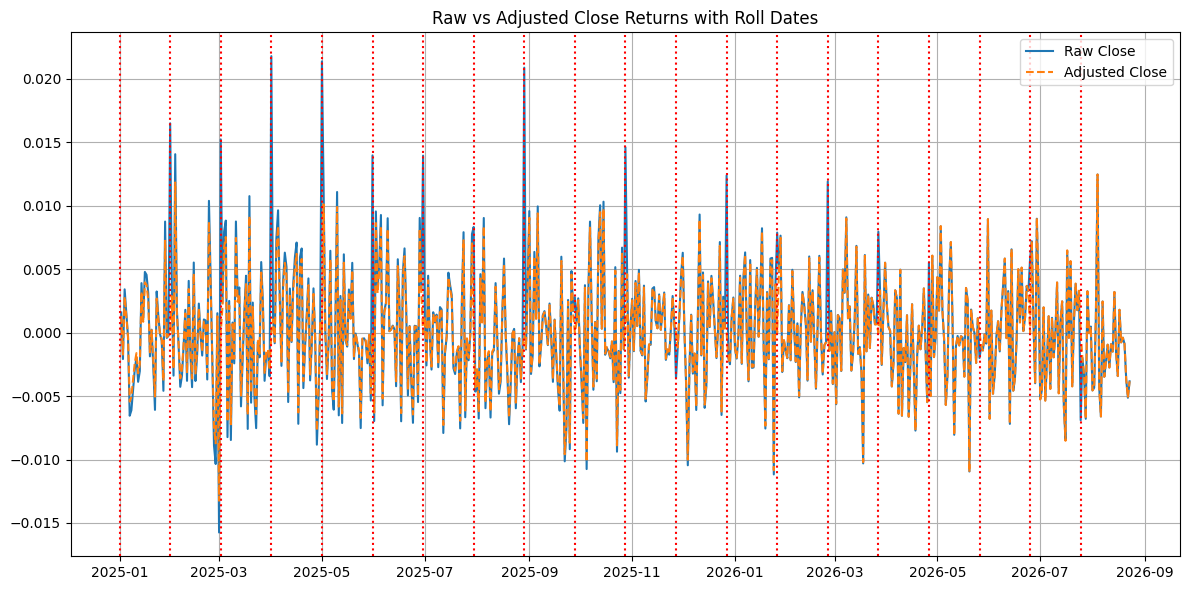

In [8]:
# Identify roll dates (i.e., where contract_id changes)
roll_dates = synthetic_df['contract_id'].ne(synthetic_df['contract_id'].shift()).loc[lambda x: x].index

plt.figure(figsize=(12, 6))
plt.plot(synthetic_df['close'].pct_change(), label='Raw Close')
plt.plot(adjusted_df['close_adj'].pct_change(), label='Adjusted Close', linestyle='--')

# Add vertical lines at roll dates
for roll_date in roll_dates:
    plt.axvline(roll_date, color='red', linestyle=':',)

plt.title("Raw vs Adjusted Close Returns with Roll Dates")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.3 NON-NEGATIVE ROLLED PRICE SERIES

In [10]:
from AFML_book_scripts import compute_non_negative_rolled_price_index

synthetic_df = generate_synthetic_futures_data()
rolled_df = compute_non_negative_rolled_price_index(synthetic_df)
rolled_df[['close', 'close_adj', 'Returns', 'Price_Index']].head()


ImportError: cannot import name 'compute_non_negative_rolled_price_index' from 'AFML_book_scripts' (c:\Users\dgalassi\quant-trading-self-study\00_books\AFML\notebooks\../scripts\AFML_book_scripts.py)

#### next